In this notebook, we will train a new sentiment classifier model from scratch with using nanoGPT as baseline. Since our task is training a sentiment classification model, we should modify the original nanoGPT architecture.

If you didn't install the required packages before, you can with the commented out line below. Otherwise, you will get errors at the first import.

In [1]:
#!pip install torch numpy transformers datasets tiktoken wandb tqdm matplotlib seaborn scipy scikit-learn emoji

In [2]:
import wandb
import pickle
import tiktoken
import torch
from torch.utils.data import DataLoader
from models.train_from_scratch import train
from data.utils.prepare_from_scratch import prepare_data
from data.utils.dataset import CustomerSentimentDataset
from models.evaluate_from_scratch import plot_confusion_matrix, evaluate

[nltk_data] Downloading package stopwords to /home/eren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


At first, we will load our data.

In [3]:
df_input = prepare_data()
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   issue_area                   1000 non-null   object
 1   issue_category               1000 non-null   object
 2   issue_sub_category           1000 non-null   object
 3   issue_category_sub_category  1000 non-null   object
 4   customer_sentiment           1000 non-null   object
 5   product_category             1000 non-null   object
 6   product_sub_category         1000 non-null   object
 7   issue_complexity             1000 non-null   object
 8   agent_experience_level       1000 non-null   object
 9   agent_experience_level_desc  1000 non-null   object
 10  conversation                 1000 non-null   object
 11  data_split_type              1000 non-null   object
 12  sentiment                    1000 non-null   int64 
 13  text_cleaned                 1000 

There are 1000 observations in train and test datasets in sum. We investigated the data in [1_eda.ipynb](1_eda.ipynb) and [2_preprocessing.ipynb](2_preprocessing.ipynb) notebooks, so we won't repeat that steps here.

During training, we will use W&B for hyperparameter optimization. Before training, we should define our parameters and parameter values to be tested. During development process, different parameters and values have tested. At below, only the best configuration of the parameter values have given.

In [4]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 50
        },
        'batch_size': {
            'values': [32]
        },
        'vocab_size': {
            'values': [50304]
        },
        'block_size': {
            'values': [1024]
        },
        'n_layer': {
            'values': [6]
        },
        'n_head': {
            'values': [6]
        },
        'n_embd': {
            'values': [384]
        },
        'dropout': {
            'values': [0.3]
        },
        'learning_rate': {
            'values': [0.0001]
        },
        'weight_decay': {
            'values': [0.01]
        },
        'max_grad_norm': {
            'values': [1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'scratch'
        },
    }
}

We defined a train() method that is compatible with W&B and trains and evaluates the model. This method also saves the best performed model to local storage. Also, all metrics and charts will be saved to W&B. Now, we can start our training process.

In [5]:
sweep_id = wandb.sweep(sweep_config, project="DI725_assignment_1_2389088_from_scratch")
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 9kjr5i1v
Sweep URL: https://wandb.ai/erennarin-92-metu-middle-east-technical-university/DI725_assignment_1_2389088_from_scratch/sweeps/9kjr5i1v


wandb: Agent Starting Run: j5jcb5ie with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	block_size: 1024
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	init_from: scratch
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 1
wandb: 	n_embd: 384
wandb: 	n_head: 6
wandb: 	n_layer: 6
wandb: 	vocab_size: 50304
wandb: 	weight_decay: 0.01
wandb: Currently logged in as: erennarin-92 (erennarin-92-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


number of parameters: 29.96M
num decayed parameter tensors: 27, with 30,327,936 parameters
num non-decayed parameter tensors: 50, with 30,720 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.79, Train F1 Macro: 0.36, Train Precision Macro: 0.41, Train Recall Macro: 0.46, Train Accuracy: 0.54
Epoch 1, Val Loss: 0.76, Val F1 Macro: 0.32, Val Precision Macro: 0.44, Val Recall Macro: 0.37, Val Accuracy: 0.59

Epoch 2, Train Loss: 0.72, Train F1 Macro: 0.47, Train Precision Macro: 0.56, Train Recall Macro: 0.54, Train Accuracy: 0.61
Epoch 2, Val Loss: 0.89, Val F1 Macro: 0.32, Val Precision Macro: 0.43, Val Recall Macro: 0.37, Val Accuracy: 0.59

Epoch 3, Train Loss: 0.69, Train F1 Macro: 0.55, Train Precision Macro: 0.61, Train Recall Macro: 0.59, Train Accuracy: 0.66
Epoch 3, Val Loss: 0.72, Val F1 Macro: 0.45, Val Precision Macro: 0.48, Val Recall Macro: 0.46, Val Accuracy: 0.70

Epoch 4, Train Loss: 0.58, Train F1 Macro: 0.64, Train Precision Macro: 0.69, Train Recall Macro: 0

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▄▄▅▆▇▇▇▆▇▇▇▇█▇████████████████████████
train_f1_macro,▁▂▃▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▆▇▇███▇███████████████
train_loss,█▇▆▆▅▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train_precision_macro,▁▃▃▄▄▅▅▆▆▆▅▆▆▆▆▆▆▆▆▆▇▇██████████████████
train_recall_macro,▁▂▃▄▄▄▅▅▆▅▆▆▆▆▆▆▆▆▆▇███▇████████████████
val_accuracy,▁▁▄▅▅▂▂▇▆▄▇▇▅▇▇▆▆▆▇▆▇▇▇▇▇██▇█▄██▇▇▇█▆▇▇▇
val_f1_macro,▁▁▃▄▄▃▃▅▅▄▅▅▄▅▅▅▄▄▅▄▅▇▇█▇▇██▇▇▇█▆▇▅█▇▇▆█
val_loss,▂▂▁▂▁▄▁▂▃▄▂▄▂▂▂▄▃▂▄▄▂▂▃▃▃▂▄▄▃█▃▃▄▅▅▃▆▅▅▅
val_precision_macro,▁▁▂▂▂▂▂▃▃▂▃▃▂▃▃▂▂▃▂█▅▅▅▅▅▅▅▄▅▆▆▆▅▄▃▆▆███
val_recall_macro,▁▁▂▃▃▃▃▄▄▃▄▄▃▄▄▄▄▄▄▄▄▇▇██▇▇▇▆▆▆▅▆▄▅▇▆▅▅▆


Run j5jcb5ie errored:
Traceback (most recent call last):
  File "/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/home/eren/Drive/METU/Courses/[DI 725] Transformers and Attention-Based Deep Networks/Assignments/Assignment 1/DI725_assignment1/models/train_from_scratch.py", line 116, in train
    model.load_state_dict(torch.load(best_model_path)['model'])
  File "/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/torch/serialization.py", line 1425, in load
    with _open_file_like(f, "rb") as opened_file:
  File "/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/torch/serialization.py", line 751, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/torch/serialization.py", line 732, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [E

In [6]:
model_path = '../models/3_nanoGPT_sentiment_model.pkl'
loaded_model = pickle.load(open(model_path, 'rb'))

Since nanoGPT a small and easy trainable model architecture, this training only took ~12 minutes on RTX 3080 Laptop GPU. Now we can test our trained model on test dataset.

We should tokenize the test values like we did to train and test values. So, we used the same classes and the methods to tokenize test values.

In [7]:
tokenizer = tiktoken.get_encoding("gpt2")
test_dataset = CustomerSentimentDataset(df_input[df_input.data_split_type == 'test'], max_length=1024,
                                        tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Test Loss: 3.19, Test F1 Macro: 0.59, Test Precision Macro: 0.76, Test Recall Macro: 0.63, Test Accuracy: 0.63


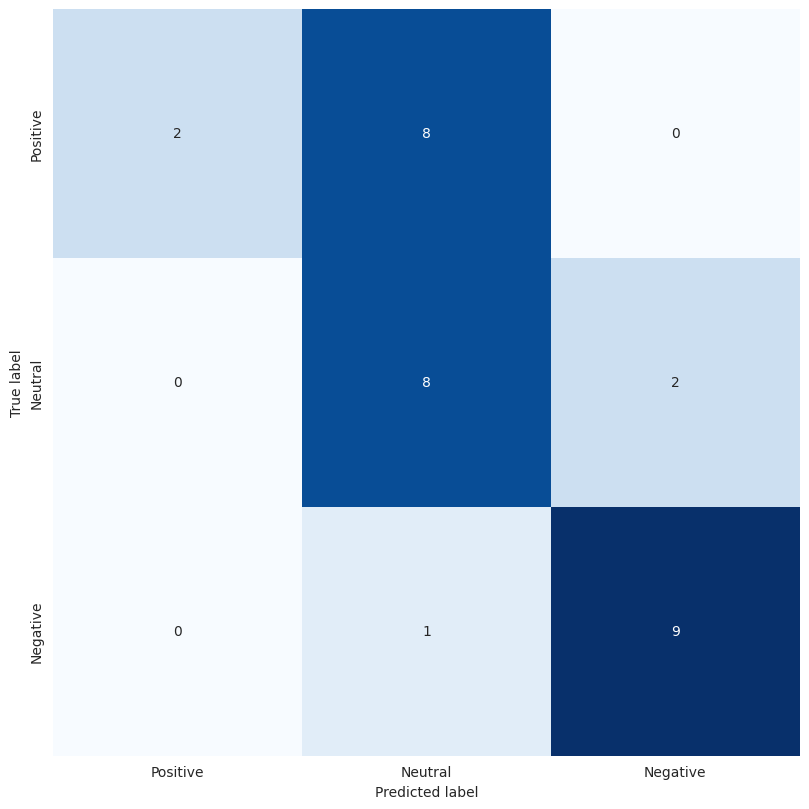

Error: You must call wandb.init() before wandb.log()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_loss, test_f1, test_prec, test_rec, test_acc, test_conf_matrix = evaluate(loaded_model, test_loader, device)
print(
    f"Test Loss: {test_loss:.2f}, Test F1 Macro: {test_f1:.2f}, Test Precision Macro: {test_prec:.2f}, Test Recall Macro: {test_rec:.2f}, Test Accuracy: {test_acc:.2f}")

plot_confusion_matrix(test_conf_matrix, class_names=['Positive', 'Neutral', 'Negative'])

In this training, the model has performed with 63% accuracy on test dataset. As we can see on confusion matrix, the model classified the neutral and negative inputs well, however it failed to classify positive examples correctly. This is expected, because our dataset is a biased one. There are very few positive examples in both train and test sets. To increase performance on minority classes, we can collect more data or augment data with new samples from minority classes.